# Bayesian analysis of tests with unknown specificity and sensitivity

**Authors:** Andrew Gelman and Bob Carpenter 

Reparametrization: https://mc-stan.org/docs/2_18/stan-users-guide/reparameterization-section.html

Data types: https://mc-stan.org/docs/2_19/reference-manual/univariate-data-types-and-variable-declarations.html

We redo the work developed in the article as exercise using `pystan`. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

sns.set()
plt.rc('mathtext', fontset="cm")

from scipy.special import expit
import pystan as ps

import pickle

ro = np.random.RandomState(1000)

Prevalence estimates (proportion of some characteristic in a population) is sensible to uncertainty in specificicity and sensitivity of the test. Hierarchical modelling is used with bayesian inference to model it in three different models. 

from scipy.special import expit
## Model 1

$$y \sim Bin(n,p),$$
$$p = (1 - \gamma)(1 - \pi) + \delta \pi,$$
$$y_{\gamma} \sim Bin(n_{\gamma}, \gamma),$$
$$y_{\delta} \sim Bin(n_{\delta}, \delta),$$

In [1]:
compiled = True

In [3]:
if compiled: 
    sm = pickle.load(open('../models/prevalence_estimation/pickles/model1.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/prevalence_estimation/stan_codes/model1.stan', extra_compile_args=["-w"])
    with open('../models/prevalence_estimation/pickles/model1.pkl', 'wb') as f:
        pickle.dump(sm, f)

## Data

We fit the model by using the data reported in Bendavid et al. (2020a).

In [4]:
n_sample = 3300 
n_spec   = 401
n_sens   = 122

y = 50
y_spec = 399
y_sens = 103

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "n_sens": n_sens
}

## Fitting the model

Consider the following hyperparameters and fit the model. 

In [5]:
tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   1,
      "beta_pi":    1,
})

In [6]:
fit = sm.sampling(data=tests_data, iter=10000, chains=2)

In [7]:
print(fit)

Inference for Stan model: anon_model_0a75e7cf69af7868ab6ce6b4d4cf5344.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
spec         0.99  5.8e-5 3.3e-3   0.99   0.99   0.99    1.0    1.0   3322    1.0
sens         0.84  4.5e-4   0.03   0.77   0.82   0.84   0.86    0.9   5309    1.0
pi           0.01  7.6e-5 4.6e-3 1.7e-3 7.5e-3   0.01   0.01   0.02   3628    1.0
p            0.02  2.0e-5 2.1e-3   0.01   0.01   0.02   0.02   0.02  10883    1.0
spec_prior    0.5  2.9e-3   0.29   0.02   0.25    0.5   0.75   0.97  10138    1.0
sens_prior    0.5  2.9e-3   0.29   0.02   0.25    0.5   0.75   0.98  10001    1.0
pi_prior      0.5  2.9e-3   0.29   0.03   0.26   0.51   0.76   0.97   9643    1.0
p_prior       0.5  2.3e-3   0.24   0.08   0.32    0.5   0.69   0.93  10243    1.0
lp__       -337.7    0.02    1.3 -341.0 -338.2 -337.4 -336.7 -336.2   2

### Posterior checking

Plotting the posterior distributions and scatter plots. 

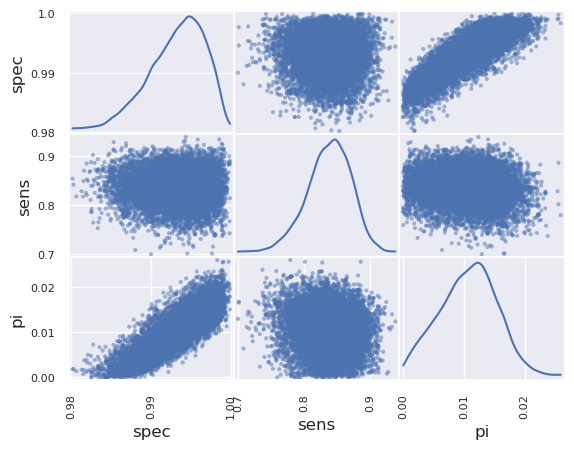

In [8]:
df_trace = pd.DataFrame(fit.extract(['spec', 'sens', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

### Prior checking 

Below we see the iinduced prior distribution on $p$. Despite setting flat priors for all parameters, we observe a non plat prior on $p$. 

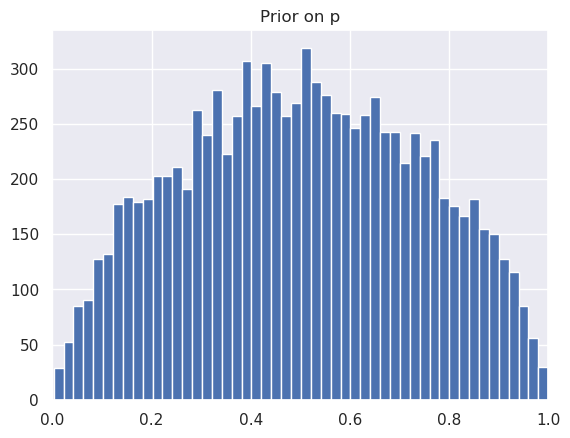

In [9]:
plt.hist(fit.extract()['p_prior'], bins = 50)
plt.title("Prior on p")
plt.xlim((0,1))
plt.show()

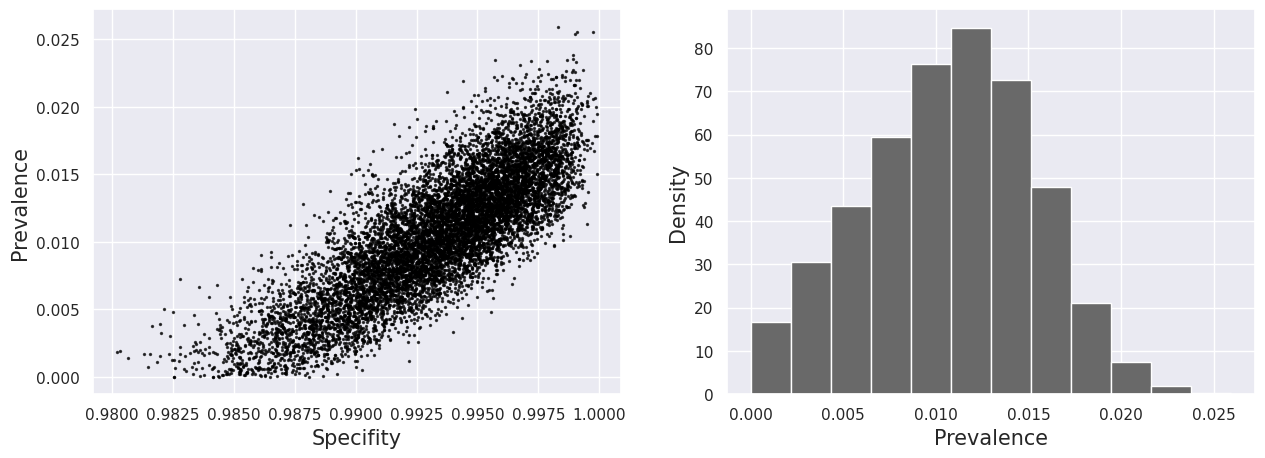

In [10]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

ax[0].scatter(fit.extract()['spec'], fit.extract()['pi'], s = 2, color = 'black', alpha = 0.7);
ax[0].set_xlabel('Specifity', fontsize = 15)
ax[0].set_ylabel('Prevalence', fontsize = 15)

ax[1].hist(fit.extract()['pi'], color = 'dimgrey', bins = 12, density = True)
ax[1].set_ylabel('Density', fontsize = 15)
ax[1].set_xlabel('Prevalence', fontsize = 15);

plt.savefig('../../images/model1_gelman_figure_english.png', bbox_inches='tight',dpi=500)
plt.show()

## Other hyperpriors

We test some other values. 

In [54]:
tests_data.update({
      "alpha_spec": 1,
      "beta_spec":  1,
      "alpha_sens": 1,
      "beta_sens":  1,
      "alpha_pi":   0.01,
      "beta_pi":    0.19,
})

fit = sm.sampling(data=tests_data, iter=10000, chains=2, control=dict(adapt_delta=0.96))
print(fit)

Inference for Stan model: anon_model_0a75e7cf69af7868ab6ce6b4d4cf5344.
2 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=10000.

             mean se_mean     sd     2.5%     25%     50%     75%  97.5%  n_eff   Rhat
spec         0.93  3.5e-4   0.02     0.87    0.91    0.93    0.94   0.97   4758    1.0
sens         0.91  8.5e-4   0.06     0.76    0.88    0.92    0.95   0.99   5163    1.0
pi         1.7e-3  1.2e-4 7.4e-3  2.2e-16 1.3e-12  9.2e-9  2.9e-5   0.02   3990    1.0
p            0.07  3.2e-4   0.02     0.04    0.06    0.07    0.09   0.13   5335    1.0
spec_prior    0.5  2.9e-3   0.29     0.02    0.25    0.51    0.75   0.98   9861    1.0
sens_prior    0.5  2.9e-3   0.29     0.03    0.26     0.5    0.75   0.97   9831    1.0
pi_prior     0.05  2.0e-3    0.2 2.7e-154 6.8e-58 1.8e-28 3.1e-11   0.98  10098    1.0
p_prior       0.5  2.9e-3   0.29     0.03    0.25    0.49    0.75   0.97  10028    1.0
lp__       -40.14    0.02 

Changing the prior distribution on $\pi$ (reduced the mean by 10), the induced on $p$ is more uniform! 

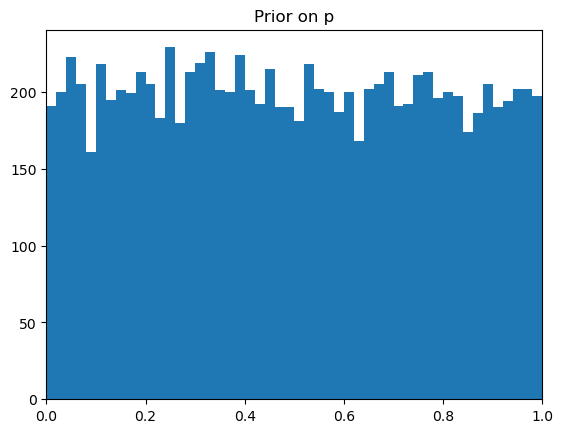

In [55]:
plt.hist(fit.extract()['p_prior'], bins = 50)
plt.title("Prior on p")
plt.xlim((0,1))
plt.show()

## Model 2

Now we adapt to a hierarchical model

$$
logit(\gamma_j) \sim normal(\mu_{\gamma}, \sigma_{\gamma}) \\
logit(\delta_j) \sim normal(\mu_{\delta}, \sigma_{\delta})
$$

where $j=1,...,J$ are studies for each parameter. 

**Remark:** The reparameterization of `logit_spec` and `logit_sens` with offset and multiplier, we obtain a non-central distribution wahat is computationally better. 

In [77]:
compiled = True

In [82]:
if compiled: 
    sm2 = pickle.load(open('../models/prevalence_estimation/pickles/model2.pkl', 'rb'))
else: 
    sm2 = ps.StanModel(file = '../models/prevalence_estimation/stan_codes/model2.stan', extra_compile_args=["-w"])
    with open('../models/prevalence_estimation/pickles/model2.pkl', 'wb') as f:
        pickle.dump(model, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f03490079dc5cd0799978ea307a407af NOW.


## Data

First we simulate the data based on the second model.

In [83]:
n_sample = 100

J_spec   = 5
n_spec   = np.array([10,30,15,20,40])
J_sens   = 5
n_sens   = np.array([10,30,15,20,40])

mu_spec = np.array([2.5, 3.5, 2.2, 4.1, 3.2])
mu_sens = np.array([2.5, 3.5, 2.2, 4.1, 3.2])

sigma_spec = np.array([0.5, 0.2, 0.6, 0.1, 0.2])
sigma_sens = np.array([0.5, 0.2, 0.6, 0.1, 0.2])

spec = expit(ro.normal(loc = mu_spec, scale = sigma_spec))
sens = expit(ro.normal(loc = mu_spec, scale = sigma_spec))

pi   = 0.01
p    = (1 - spec[0])*(1 - pi) + sens[0]*pi

y      = ro.binomial(n=n_sample, p=p)
y_spec = ro.binomial(n=n_spec, p=spec)
y_sens = ro.binomial(n=n_sens, p=sens)

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "J_spec": J_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "J_sens": J_sens,
    "n_sens": n_sens
}

## Fitting the model

Consider the following hyperparameters and fit the model. 

In [84]:
tests_data.update({
      "alpha_pi"             : 0.1,
      "beta_pi"              : 1.9,  
      "mean_hyper_mean_spec" : 3,
      "mean_hyper_mean_sens" : 3, 
      "sd_hyper_mean_spec"   : 2,
      "sd_hyper_mean_sens"   : 2,
      "sd_hyper_sd_spec"     : 1,
      "sd_hyper_sd_sens"     : 1,
})

In [85]:
fit2 = sm2.sampling(data=tests_data, iter=3000, chains=4, control=dict(adapt_delta=0.95))

In [86]:
print(fit2)

Inference for Stan model: anon_model_f03490079dc5cd0799978ea307a407af.
4 chains, each with iter=3000; warmup=1500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=6000.

                        mean se_mean     sd    2.5%    25%    50%    75%  97.5%  n_eff   Rhat
pi                      0.07  1.5e-3   0.05 1.0e-10   0.02   0.07   0.11   0.17   1170    1.0
mean_logit_spec          3.3    0.01   0.64    2.19   2.85   3.25    3.7   4.69   2433    1.0
mean_logit_sens         4.81    0.01   0.94    3.19   4.16   4.72   5.39   6.87   5477    1.0
sd_logit_spec           0.58  7.4e-3   0.45    0.02   0.23   0.48   0.82    1.7   3738    1.0
sd_logit_sens           0.67  7.2e-3   0.53    0.02   0.26   0.56   0.96    2.0   5437    1.0
logit_spec[1]            3.2    0.02   0.93    1.82   2.51    3.1   3.72   5.34   1552    1.0
logit_spec[2]           3.35  9.5e-3    0.7    2.18   2.87    3.3   3.77   4.91   5458    1.0
logit_spec[3]           3.19    0.01   0.73    1.88   2.71 

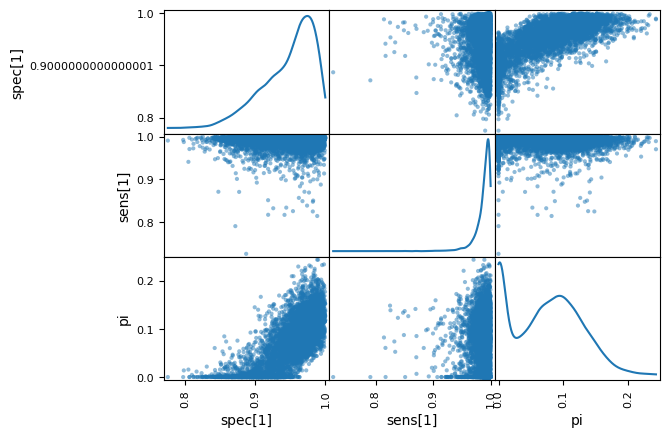

In [87]:
df_trace = pd.DataFrame(fit2.extract(['spec[1]', 'sens[1]', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()

## Other hyperpriors

In [88]:
tests_data.update({
      "alpha_pi"             : 0.001,
      "beta_pi"              : 0.019,  
      "mean_hyper_mean_spec" : 0.5,
      "mean_hyper_mean_sens" : 0.5, 
      "sd_hyper_mean_spec"   : 0.5,
      "sd_hyper_mean_sens"   : 0.5,
      "sd_hyper_sd_spec"     : 0.5,
      "sd_hyper_sd_sens"     : 0.5,
})

fit2 = sm2.sampling(data=tests_data, iter=2000, chains=4, control=dict(adapt_delta=0.95, max_treedepth=12))
print(fit2)

Inference for Stan model: anon_model_f03490079dc5cd0799978ea307a407af.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd    2.5%     25%      50%      75%  97.5%  n_eff   Rhat
pi                    6.2e-3  5.1e-4   0.02 2.2e-16 1.1e-12   9.3e-9   5.9e-5   0.08   1683    1.0
mean_logit_spec         1.92    0.01   0.37    1.03    1.72     1.97     2.18   2.55    968    1.0
mean_logit_sens         1.98    0.01   0.49    0.95    1.67     2.03     2.34   2.83   1390    1.0
sd_logit_spec           0.52    0.01   0.37    0.03    0.21     0.46     0.75   1.36   1040    1.0
sd_logit_sens           0.87    0.01   0.46    0.07    0.52     0.87     1.21   1.77   1308    1.0
logit_spec[1]           2.09  6.2e-3   0.33    1.56    1.89     2.07     2.25   2.77   2806    1.0
logit_spec[2]            2.4  8.9e-3    0.5    1.59    2.07     2.32     2.66    3.6   3221    1.0
logit_spec[3]      

## Considering bivariate beta distribution

Taking the bivariate form discussed in the notebook `bivariate_beta.ipynb`, we modified the first model a little. 

In [42]:
compiled = False

In [43]:
if compiled: 
    sm = pickle.load(open('../models/prevalence_estimation/pickles/model1_bivariate.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = '../models/prevalence_estimation/stan_codes/model1_bivariate_const.stan', extra_compile_args=["-w"])
    with open('../models/prevalence_estimation/pickles/model1_bivariate.pkl', 'wb') as f:
        pickle.dump(sm, f)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_46a5b7cd86748b5dc4d941f7171c5fe4 NOW.


### Data

In [44]:
n_sample = 3300 
n_spec   = 401
n_sens   = 122

y = 50
y_spec = 399
y_sens = 103

tests_data = {
    "positive_tests": y,
    "number_tests": n_sample,
    "neg_tests_neg_subj": y_spec,
    "n_spec": n_spec,
    "pos_tests_pos_subj": y_sens,
    "n_sens": n_sens
}

### Fitting the model

In [45]:
tests_data.update({
      "alpha": [10,1,1,1],
      "alpha_pi":   0.01,
      "beta_pi":    0.19,
})

fit = sm.sampling(data=tests_data, iter=10000, chains=1, control=dict(adapt_delta=0.9))
print(fit)

Inference for Stan model: anon_model_46a5b7cd86748b5dc4d941f7171c5fe4.
1 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=5000.

       mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
U[1]   0.85  1.4e-3   0.03    0.78    0.83   0.85   0.87    0.9    463    1.0
U[2]   0.14  9.1e-4   0.03    0.09    0.12   0.14   0.16    0.2   1000    1.0
U[3] 6.2e-3  3.8e-4 4.2e-3  4.8e-4  2.4e-3 5.5e-3 9.4e-3   0.01    123   1.02
U[4] 6.9e-3  2.6e-4 4.0e-3  5.3e-4  3.7e-3 6.3e-3   0.01   0.01    238   1.01
pi   1.8e-3  8.3e-4 3.7e-3 4.4e-16 6.4e-12 7.9e-8 7.4e-4   0.01     20   1.08
spec   0.99  7.4e-4 3.5e-3    0.98    0.98   0.99   0.99   0.99     22   1.07
sens   0.85  1.0e-3   0.03    0.79    0.83   0.85   0.87   0.91    798    1.0
p      0.01  4.0e-5 2.0e-3    0.01    0.01   0.01   0.02   0.02   2492    1.0
lp__ -341.3    0.06   1.27  -344.4  -341.9 -341.0 -340.4 -339.8    467    1.0

Samples were drawn using NUTS

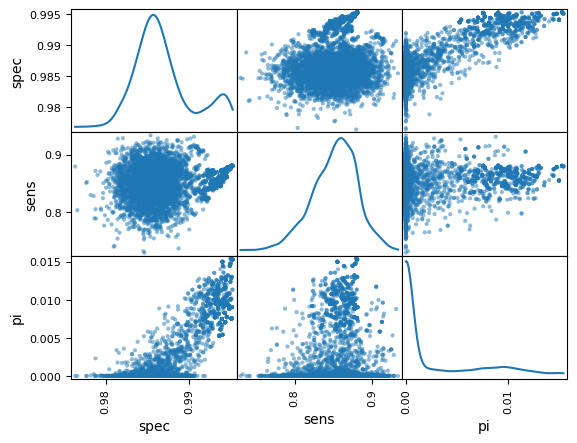

In [46]:
df_trace = pd.DataFrame(fit.extract(['spec', 'sens', 'pi']))
pd.plotting.scatter_matrix(df_trace[:], diagonal='kde');
plt.show()